In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import pandas_profiling as pl
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.
#### **Dataset characteristics**
* Data Fields	
	* instant: record index
	* dteday : date
	* season : season (1:springer, 2:summer, 3:fall, 4:winter)
	* yr : year (0: 2011, 1:2012)
	* mnth : month ( 1 to 12)
	* hr : hour (0 to 23)
	* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday*schedule)
	* weekday : day of the week
	* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	* temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	* atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	* hum: Normalized humidity. The values are divided to 100 (max)
	* windspeed: Normalized wind speed. The values are divided to 67 (max)
	* casual: count of casual users
	* registered: count of registered users
	* cnt: count of total rental bikes including both casual and registered

In [2]:
hourlyData = pd.read_csv("data/hour.csv")
hourlyData.columns = [
    "instant",
    "timestamp",
    "season",
    "year",
    "month",
    "hour",
    "holiday",
    "weekday",
    "workingday",
    "weather",
    "temp",
    "atemp",
    "humidity",
    "windspeed",
    "casual",
    "registered",
    "count",
]


## Data Summary

In [3]:
# report = pl.ProfileReport(hourlyData)
# report


#### **Shape Of The Dataset**

In [4]:
hourlyData.shape


(17379, 17)

#### **Sample Of First Few Rows**

In [5]:
hourlyData.head()


,instant,timestamp,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### **Variables Data Type**

In [6]:
hourlyData.dtypes


instant         int64
timestamp      object
season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. We need to coerce the datatype of "season","holiday","workingday" and weather to category.

In [7]:
hourlyData["weekday"] = hourlyData.timestamp.apply(
    lambda dateString: calendar.day_name[
        datetime.strptime(dateString, "%Y-%m-%d").weekday()
    ]
)
hourlyData["month"] = hourlyData.timestamp.apply(
    lambda dateString: calendar.month_name[
        datetime.strptime(dateString, "%Y-%m-%d").month
    ]
)
hourlyData["season"] = hourlyData.season.map(
    {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
)
hourlyData["weather"] = hourlyData.weather.map(
    {
        1: " Clear",
        2: " Mist, Cloudy",
        3: " Light Snow, Rain, Thunder",
        4: " Heavy Snow, Rain, Thunder",
    }
)


In [8]:
categoryVariableList = [
    "weekday",
    "year",
    "month",
    "season",
    "weather",
    "holiday",
    "workingday",
    "hour",
]
for var in categoryVariableList:
    hourlyData[var] = hourlyData[var].astype("category")


#### **Visualization Of Variables DataType Count**

[Text(0.5, 0, 'variableType'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

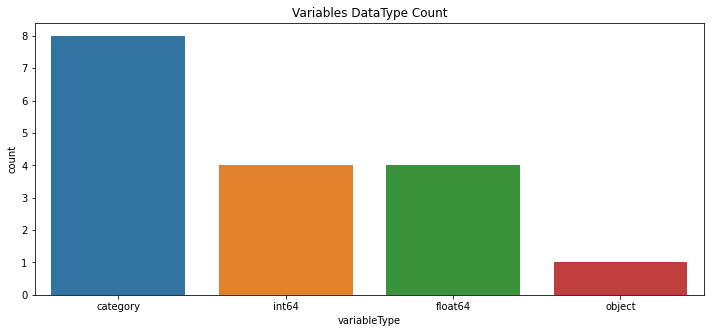

In [9]:
dataTypeDf = (
    pd.DataFrame(hourlyData.dtypes.astype("str").value_counts())
    .reset_index()
    .rename(columns={"index": "variableType", 0: "count"})
)
dataTypeDf["variableType"] = [str(x) for x in list(dataTypeDf["variableType"])]
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sn.barplot(data=dataTypeDf, x="variableType", y="count", ax=ax)
ax.set(xlabel="variableType", ylabel="count", title="Variables DataType Count")


## Missing Values Analysis

In [10]:
hourlyData.isna().sum()


instant       0
timestamp     0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Outliers Analysis ##

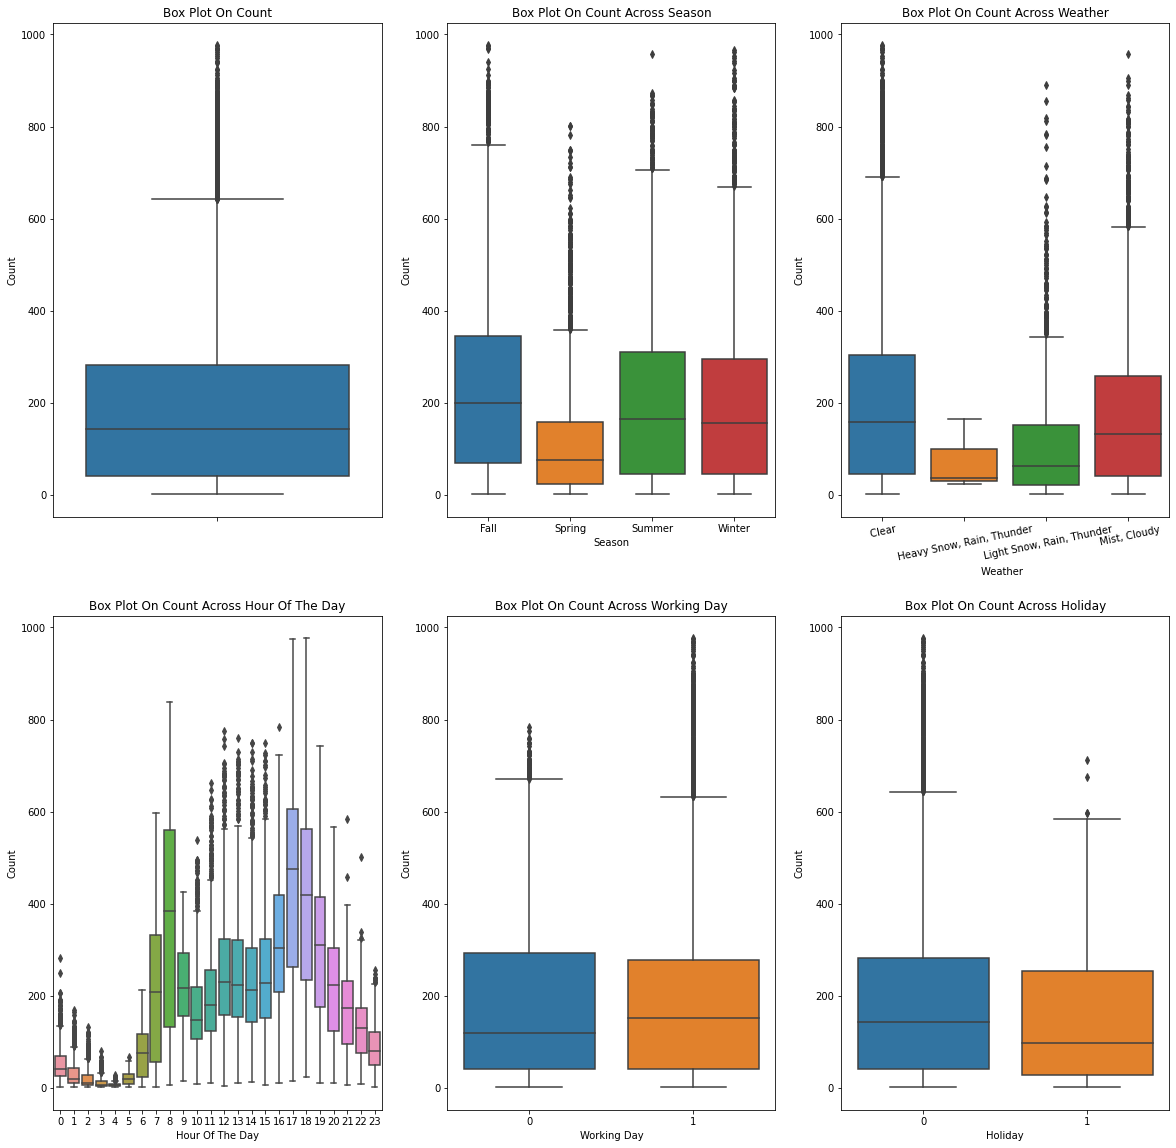

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 20)
sn.boxplot(data=hourlyData, y="count", orient="v", ax=axes[0][0])
sn.boxplot(data=hourlyData, y="count", x="season", orient="v", ax=axes[0][1])
sn.boxplot(data=hourlyData, y="count", x="weather", orient="v", ax=axes[0][2])
sn.boxplot(data=hourlyData, y="count", x="hour", orient="v", ax=axes[1][0])
sn.boxplot(data=hourlyData, y="count", x="workingday", orient="v", ax=axes[1][1])
sn.boxplot(data=hourlyData, y="count", x="holiday", orient="v", ax=axes[1][2])

axes[0][0].set(ylabel="Count", title="Box Plot On Count")
axes[0][1].set(xlabel="Season", ylabel="Count", title="Box Plot On Count Across Season")
axes[0][2].set(
    xlabel="Weather  ", ylabel="Count", title="Box Plot On Count Across Weather"
)
axes[1][0].set(
    xlabel="Hour Of The Day",
    ylabel="Count",
    title="Box Plot On Count Across Hour Of The Day",
)
axes[1][1].set(
    xlabel="Working Day", ylabel="Count", title="Box Plot On Count Across Working Day"
)
axes[1][2].set(
    xlabel="Holiday", ylabel="Count", title="Box Plot On Count Across Holiday"
)
axes[0, 2].tick_params("x", labelrotation=12)


#### **Remove Outliers In The Count Column**

In [12]:
hourlyDataWithoutOutliers = hourlyData[
    np.abs(hourlyData["count"] - hourlyData["count"].mean())
    <= (3 * hourlyData["count"].std())
]


In [13]:
print("Shape Of The Before Ouliers: ", hourlyData.shape)
print("Shape Of The After Ouliers: ", hourlyDataWithoutOutliers.shape)


Shape Of The Before Ouliers:  (17379, 17)
Shape Of The After Ouliers:  (17135, 17)


## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

<AxesSubplot:>

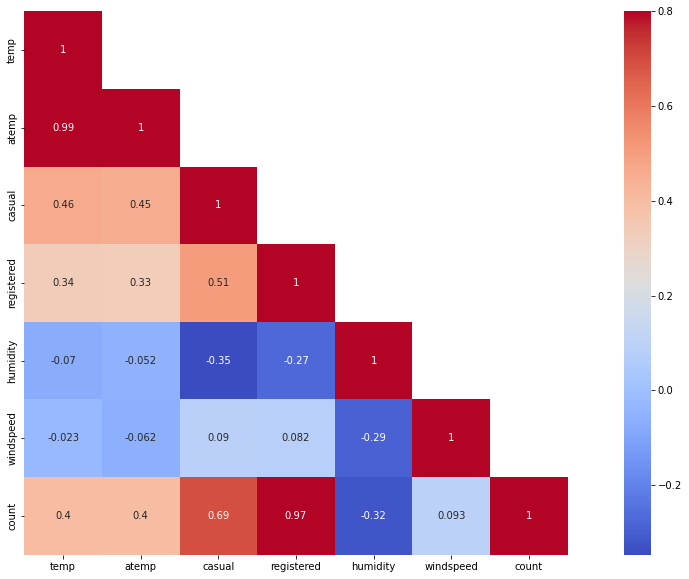

In [14]:
corrMatt = hourlyData[
    ["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]
].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corrMatt, cmap="coolwarm", mask=mask, vmax=0.8, square=True, annot=True)


<AxesSubplot:xlabel='humidity', ylabel='count'>

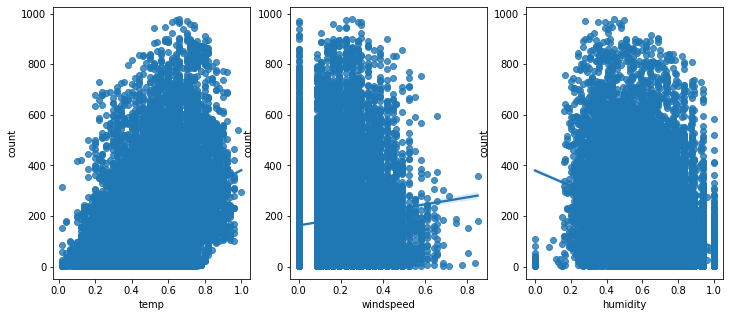

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=hourlyData, ax=ax1)
sn.regplot(x="windspeed", y="count", data=hourlyData, ax=ax2)
sn.regplot(x="humidity", y="count", data=hourlyData, ax=ax3)


## Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

/home/minhhnh/BAP-intern/EDA-Data-visualization/bike-sharing/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/minhhnh/BAP-intern/EDA-Data-visualization/bike-sharing/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.94171042, -3.72363151, -3.60421718, ...,  3.60421718,
          3.72363151,  3.94171042]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.5971457 ,
         6.59850903])),
 (1.3490324630370492, 4.544366339498316, 0.9601811537292394))

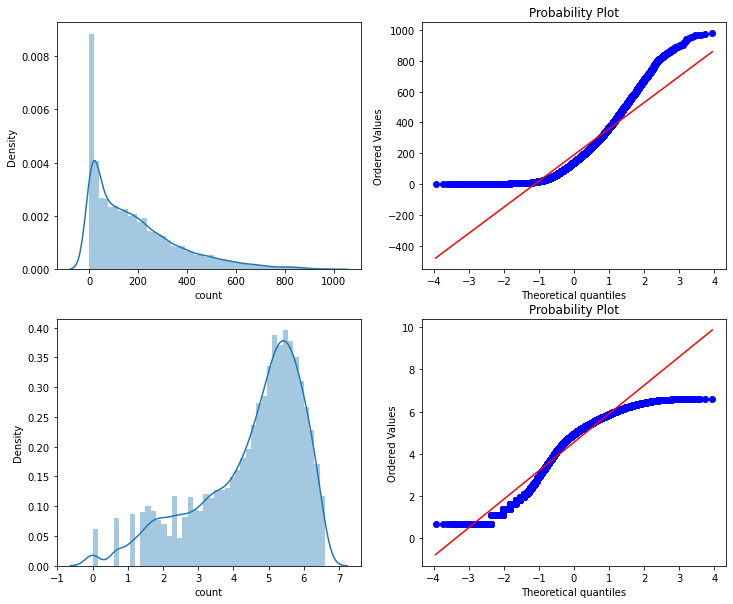

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(hourlyData["count"], ax=axes[0][0])
stats.probplot(hourlyData["count"], dist="norm", fit=True, plot=axes[0][1])
sn.distplot(np.log(hourlyDataWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(
    np.log1p(hourlyDataWithoutOutliers["count"]), dist="norm", fit=True, plot=axes[1][1]
)


## Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
 - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

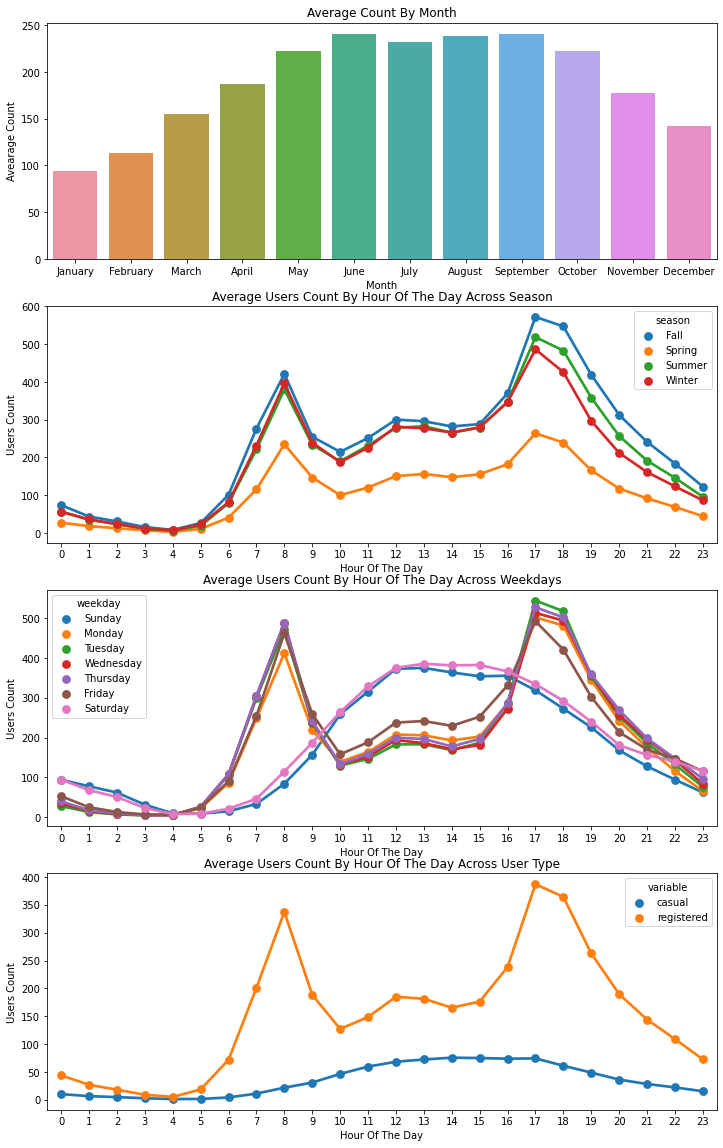

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 20)
sortOrder = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
hueOrder = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]

monthAggregated = pd.DataFrame(
    hourlyData.groupby("month")["count"].mean()
).reset_index()
monthSorted = monthAggregated.sort_values(by="count", ascending=False)
sn.barplot(data=monthSorted, x="month", y="count", ax=ax1, order=sortOrder)
ax1.set(xlabel="Month", ylabel="Avearage Count", title="Average Count By Month")

hourAggregated = pd.DataFrame(
    hourlyData.groupby(["hour", "season"], sort=True)["count"].mean()
).reset_index()
sn.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["count"],
    hue=hourAggregated["season"],
    data=hourAggregated,
    join=True,
    ax=ax2,
)
ax2.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Season",
    label="big",
)

hourAggregated = pd.DataFrame(
    hourlyData.groupby(["hour", "weekday"], sort=True)["count"].mean()
).reset_index()
sn.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["count"],
    hue=hourAggregated["weekday"],
    hue_order=hueOrder,
    data=hourAggregated,
    join=True,
    ax=ax3,
)
ax3.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across Weekdays",
    label="big",
)

hourTransformed = pd.melt(
    hourlyData[["hour", "casual", "registered"]],
    id_vars=["hour"],
    value_vars=["casual", "registered"],
)
hourAggregated = pd.DataFrame(
    hourTransformed.groupby(["hour", "variable"], sort=True)["value"].mean()
).reset_index()
sn.pointplot(
    x=hourAggregated["hour"],
    y=hourAggregated["value"],
    hue=hourAggregated["variable"],
    hue_order=["casual", "registered"],
    data=hourAggregated,
    join=True,
    ax=ax4,
)
ax4.set(
    xlabel="Hour Of The Day",
    ylabel="Users Count",
    title="Average Users Count By Hour Of The Day Across User Type",
    label="big",
)
